Выполнял Достовалов Максим

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from scipy import stats
from scipy import special

import warnings
warnings.filterwarnings("ignore")

In [68]:
data = pd.read_excel('pdn_hse_with_flags.xlsx')

data.head()

,ID loan,ID client,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30,old_user
0,1,1000,6000,25,11862.10,0,0,0,0,0
1,2,1001,9900,30,70.48,0,0,0,0,1
2,3,1002,9900,30,58.60,0,0,0,0,1
3,4,1003,5000,25,679.65,1,0,1,1,0
4,5,1004,6000,20,875.48,1,1,1,1,0


# Предобработка данных

<Axes: xlabel='pdn', ylabel='Density'>

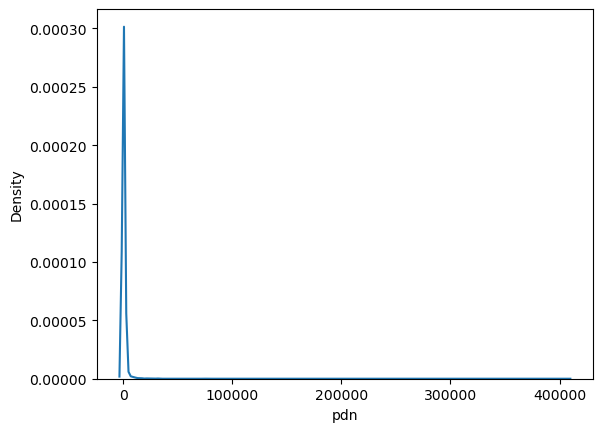

In [69]:
sns.kdeplot(data.pdn)

В исследовании переменная "pdn" демонстрирует наличие значительных выбросов, что усложняет её аналитическую обработку в первоначальном виде. Для целей данного анализа, наблюдения с значениями превышающими 10,000 будут классифицированы как выбросы.

В связи с этим, для стабилизации дисперсии и уменьшения асимметрии распределения, а также для приближения его формы к нормальному распределению, будет применено преобразование Бокса-Кокса к данной переменной. Это преобразование целенаправленно используется для обработки данных, подверженных сильным искажениям, и является методологически обоснованным подходом к решению подобных проблем анализа данных.

In [70]:
print(f'Количество удалённых выбросов: {(data.pdn > 10000).sum()}')

Количество удалённых выбросов: 46



      lambda_=-0.032
это параметр преобразования, который подбирается автоматически таким образом, чтобы максимизировать логарифмическое правдоподобие нормального распределения преобразованных данных.

Согласно тесту Шапиро-Уилка (p_value=0.0002), распределение pdn всё ещё не яваляется нормальным, но проведение статистических тестов по преобразованной переменной считается более адекватным подходом по сравнению с анализом исходных данных



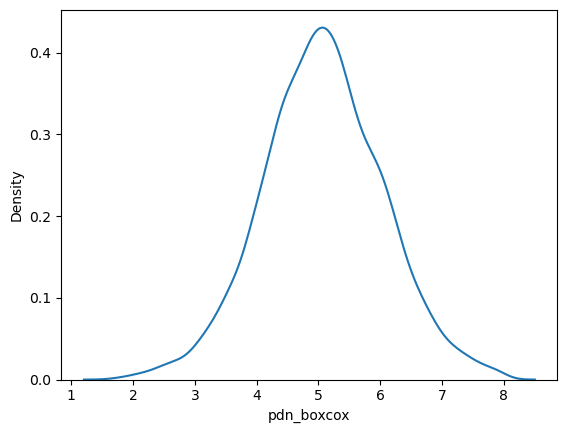

In [71]:
data = data[data.pdn < 10000]
data['pdn_boxcox'], lambda_ = stats.boxcox(data.pdn)
sns.kdeplot(data.pdn_boxcox)

print(f'''
      {lambda_=:.3f}
это параметр преобразования, который подбирается автоматически таким образом, чтобы максимизировать логарифмическое правдоподобие нормального распределения преобразованных данных.

Согласно тесту Шапиро-Уилка (p_value={stats.shapiro(data.pdn_boxcox)[1]:.4f}), распределение pdn всё ещё не яваляется нормальным, но проведение статистических тестов по преобразованной переменной считается более адекватным подходом по сравнению с анализом исходных данных
''')

### Регрессионный анализ. Регрессант - pdn

`Гипотеза`: возможно построить значимую регрессию на соотношение долга к доходу по всем имеющимся переменным

`Пометка`: 
- для правильной интерпретации моделей в дальнейшем будут использоваться робастные оценки дисперсии оценок (HC3)
- все коэффициенты будут интерпретироваться с учетом уровня значимости 5%

#### Простейшая модель для интерпретации

In [72]:
model = sm.ols(data=data, formula='pdn ~ LoanSum*old_user + LoanTerm + FPD10 + NPL10 + NPL30').fit(cov_type='HC3')

print(model.summary2())

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.067     
Dependent Variable:   pdn               AIC:                 86921.1123
Date:                 2024-03-13 22:40  BIC:                 86973.7160
No. Observations:     5300              Log-Likelihood:      -43453.   
Df Model:             7                 F-statistic:         68.40     
Df Residuals:         5292              Prob (F-statistic):  6.30e-95  
R-squared:            0.068             Scale:               7.7516e+05
-----------------------------------------------------------------------
                   Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
-----------------------------------------------------------------------
Intercept        1215.8371  74.9723  16.2171 0.0000 1068.8940 1362.7802
LoanSum            -0.0714   0.0059 -12.1926 0.0000   -0.0829   -0.0599
old_user         -724.9127  70.6814 -10.2561 0.0000 -863.4458 -586.3797
LoanSum:old_

Результат:
- Модель регрессии демонстрирует статистическую значимость в целом, однако коэффициент детерминации, отражающий долю объясненной дисперсии зависимой переменной, указывает на ограниченную объяснительную способность модели.

- 2 незначимые переменные: LoanTerm и NPL10 (в дальнейшем интерпретированы только значимые).
- переменная NPL30 имеют положительную связь с целевой переменной.
- переменные LoanSum, FPD10, NPL30, old_user имеют отрицательную связь с целевой переменной.
- оказалось важной связь между суммой кредита и тем, давним ли клиентом является пользователь. Для давних пользователей сумма кредита слабее влияет на отношение долга к доходу.

Вывод:
- Хорошим качеством этой модели является простая интерпретируемость коэффициентов, но при этом жертвой является её объясняющая способность

`Гипотеза`: 
- спецификация модели порождающей данные нелинейна, соответственно, если провести нелинейные преобразования с переменными, можно получить модель лучше
- предсказания преобразованной по Боксу-Коксу целевой переменной даст модель лучшего качества

#### Модель с преобразованной целевой переменной

- Предварительно осознавая, что коэффициенты подобной модели регрессии не поддаются количественной интерпретации, всё же возможно оценить степень влияния независимых переменных на зависимую переменную.

Для этого стандартизирую регрессоры (с целью получить регрессоры, имеющие одни и те же единицы измерения):

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_scaled = data.drop(['ID loan', 'ID client', 'pdn'], axis=1).copy()

data_scaled[['LoanSum', 'LoanTerm', 'FPD10', 'FPD30','NPL10', 'NPL30', 'old_user']]\
      = scaler.fit_transform(data_scaled[['LoanSum', 'LoanTerm', 'FPD10', 'FPD30','NPL10', 'NPL30', 'old_user']])

Построение модели:

In [74]:
model_boxcox = sm.ols(data=data_scaled, formula='pdn_boxcox ~ LoanSum + old_user + LoanTerm + FPD10 + NPL10 + NPL30').fit(cov_type='HC3')

print(model_boxcox.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.185     
Dependent Variable: pdn_boxcox       AIC:                13700.2059
Date:               2024-03-13 22:40 BIC:                13746.2341
No. Observations:   5300             Log-Likelihood:     -6843.1   
Df Model:           6                F-statistic:        246.2     
Df Residuals:       5293             Prob (F-statistic): 2.02e-278 
R-squared:          0.186            Scale:              0.77550   
--------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       5.0701    0.0121  418.9104  0.0000   5.0464   5.0938
LoanSum        -0.2905    0.0107  -27.1556  0.0000  -0.3114  -0.2695
old_user       -0.2075    0.0135  -15.3799  0.0000  -0.2340  -0.1811
LoanTerm        0.0628    0.0132    4.7596  0.0000   0.0369 

`Интерпретация`:
- видно, что модель стала лучше с точки зрения доли объяснённой дисперсии. Но R^2 является неинвариантным даже к линейным преобразованиям, поэтому сравнивать эту модель с предыдущей по этой метрике не является корректным
-  

In [75]:
def smape(y_true, y_pred):
    """
    Расчет Symmetric Mean Absolute Percentage Error (SMAPE).

    :param y_true: Массив реальных значений.
    :param y_pred: Массив предсказанных значений.
    :return: Значение SMAPE.
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)


smape_value = smape(data.pdn, model.fittedvalues)
smape_value_box_cox = smape(data.pdn_boxcox, model_boxcox.fittedvalues)

print(f'''SMAPE (на сколько % в среднем отклоняется прогноз от реальных значений таргета): 
для модели без преобразования целевой переменной = {smape_value:.2f}%
для модели c преобразованием целевой переменной = {smape_value_box_cox:.2f}%
      ''')

SMAPE (на сколько % в среднем отклоняется прогноз от реальных значений таргета): 
для модели без преобразования целевой переменной = 84.86%
для модели c преобразованием целевой переменной = 13.79%
      
